In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from math import nan
from functools import partial

from math import nan

from CASutils import averaging_utils as avg
from CASutils import mapplot_utils as mymaps
from CASutils import colorbar_utils as cbars

import cartopy.crs as ccrs

import sys
import warnings
warnings.filterwarnings('ignore')

In [2]:
plotpath="/project/cas/islas/python_plots/singleforcing_paper/figures/supplemental/"

In [3]:
landfrac = xr.open_dataset("/project/cas/islas/cesm2le/fx/LANDFRAC_LENS2.nc")

In [4]:
# to take the FSNO or ICEFRAC average only over land or ocean grid points.
notlandfrac = xr.where(np.isnan(landfrac.landfrac) | (landfrac.landfrac < 0.5), 1, nan)
landregions = xr.where(~np.isnan(landfrac.landfrac) | (landfrac.landfrac > 0.5), 1, nan) 

In [5]:
seas='djf' ; var = ['TREFHT','FSNS','FSDS','ICEFRAC']

In [6]:
# pre-processor to ensure all lon and lat coordinates are the same.  Also adding flexibility for reading in seasonal data
# Taking the ensemble mean
def preprocessor(ds):
    ds['lon'] = landfrac.lon ; ds['lat'] = landfrac.lat
    ds = ds.mean('M')
    ds['time'] = ds.time.dt.year
    ds = ds.rename({'time':'year'})
    ds = ds.sel(year=slice(1920,2050))
    return ds

### Read in CESM2 data

In [7]:
baselens2='/project/cas/islas/python_savs/singleforcing_paper/DATA_SORT/LENS2/'
lens2 = []
for ivar in var:
    dat = xr.open_mfdataset(baselens2+'LENS2_'+ivar+'_'+seas+'.nc', preprocess=partial(preprocessor))
    lens2.append(dat)
lens2 = xr.merge(lens2)
fsus = lens2.FSDS - lens2.FSNS
fsus = fsus.rename('FSUS')
lens2 = xr.merge([lens2, fsus])

In [8]:
basexaer2="/project/cas/islas/python_savs/singleforcing_paper/DATA_SORT/CESM2-XAAER/"
xaer2 = []
for ivar in var:
    dat = xr.open_mfdataset(basexaer2+'xAER_'+ivar+'_'+seas+'.nc', preprocess=partial(preprocessor))
    xaer2.append(dat)
xaer2 = xr.merge(xaer2)
fsus = xaer2.FSDS - xaer2.FSNS
fsus = fsus.rename('FSUS')
xaer2 = xr.merge([xaer2, fsus])

In [9]:
baseaer2="/project/cas/islas/python_savs/singleforcing_paper/DATA_SORT/LENS2-SF/"
aer2 = []
for ivar in var:
    dat = xr.open_mfdataset(baseaer2+'AAER_'+ivar+'_'+seas+'.nc', preprocess=partial(preprocessor))
    aer2.append(dat)
aer2 = xr.merge(aer2)
fsus = aer2.FSDS - aer2.FSNS
fsus = fsus.rename('FSUS')
aer2 = xr.merge([aer2, fsus])

### Subtract out the base period

In [10]:
lens2base = lens2.sel(year=slice(1920,1940)).mean('year')
aer2base = aer2.sel(year=slice(1920,1940)).mean('year')
xaer2base = xaer2.sel(year=slice(1920,1940)).mean('year')

In [11]:
xaer2_1960to1980 = xaer2.sel(year=slice(1960,1980)).mean('year').load() # for plotting sea ice edge

In [12]:
lens2 = lens2 - lens2base
aer2 = aer2 - aer2base
xaer2 = xaer2 - xaer2base

In [13]:
aer2xway = lens2 - xaer2

### Average over the 50N-90N region

In [14]:
aer2['ICEFRAC'] = notlandfrac*aer2.ICEFRAC
aer2xway['ICEFRAC'] = notlandfrac*aer2xway.ICEFRAC

#aer2['FSNO'] = landregions*aer2.FSNO
#aer2xway['FSNO'] = landregions*aer2xway.FSNO

aer2_nh = avg.cosweightlonlat(aer2, 0, 360, -90, -50)
aer2xway_nh = avg.cosweightlonlat(aer2xway, 0, 360, -90, -50)

### Calculate the 21 year running mean

In [15]:
# 21 year running means
def calc21ymean(dat):
    datm = dat.rolling(year=21, min_periods=21, center='True').mean('year').dropna('year')
    return datm

In [16]:
aer2_nh_21y = calc21ymean(aer2_nh).load()
aer2xway_nh_21y = calc21ymean(aer2xway_nh).load()

In [17]:
cesm2boot = xr.open_dataset("/project/cas/islas/python_savs/singleforcing_paper/DATA_SORT/BOOTSTRAP/figS8/CESM2_bootstrap.nc")
cesm2bootfsus = xr.open_dataset("/project/cas/islas/python_savs/singleforcing_paper/DATA_SORT/BOOTSTRAP/figS8/CESM2_bootstrap_Albedo_FSUS.nc")

### Plot the plot

In [18]:
aer2_1960to1980 = aer2.sel(year=slice(1960,1980)).mean('year').load()
aer2xway_1960to1980 = aer2xway.sel(year=slice(1960,1980)).mean('year').load()

In [19]:
import importlib
importlib.reload(mymaps)

<module 'CASutils.mapplot_utils' from '/home/islas/python/CASanalysis/CASutils/mapplot_utils.py'>

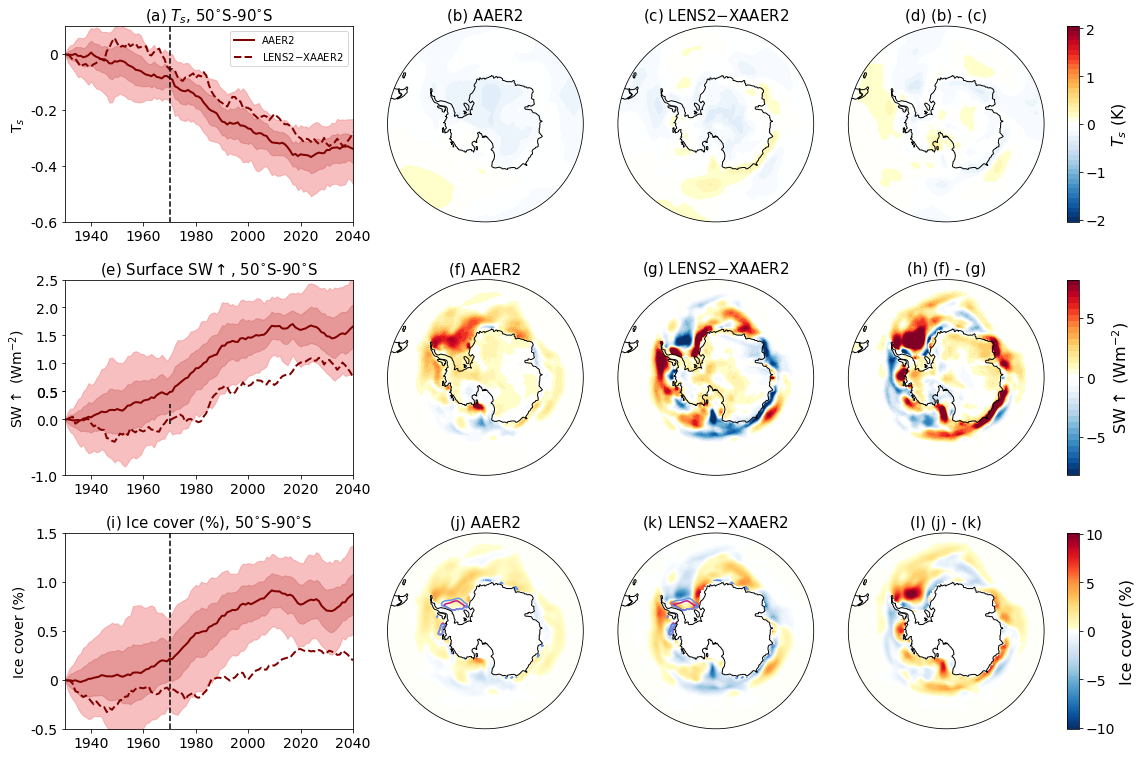

In [20]:
fig = plt.figure(figsize=(16,16))

#------------------TREFHT
ax = fig.add_axes([0.02,0.85,0.25,0.17])
ax.fill_between(cesm2boot.year, cesm2boot.TREFHT_min95_3, cesm2boot.TREFHT_max95_3, color='lightcoral', alpha=0.5)
ax.fill_between(cesm2boot.year, cesm2boot.TREFHT_min95, cesm2boot.TREFHT_max95, color='indianred', alpha=0.4)
ax.plot(aer2_nh_21y.year, aer2_nh_21y.TREFHT, color='maroon', linewidth=2, label='AAER2')
ax.plot(aer2xway_nh_21y.year, aer2xway_nh_21y.TREFHT, color='maroon', linewidth=2, linestyle='dashed', label='LENS2$-$XAAER2')
ax.set_ylim(-0.6,0.1)
ax.set_yticks([-0.6,-0.4,-0.2,0])
ax.set_yticklabels(['-0.6','-0.4','-0.2','0'], fontsize=14)
ax.set_ylabel('T$_{s}$', fontsize=14)
ax.set_title('(a) $T_{s}$, 50$^{\circ}$S-90$^{\circ}$S', fontsize=15)
ax.set_xticks([1940,1960,1980,2000,2020,2040])
ax.set_xticklabels(['1940','1960','1980','2000','2020','2040'], fontsize=14)
ax.set_xlim(1930,2040)

ax.plot([1970,1970],[-1,0.1], color='black', linestyle='dashed')

ax.legend(loc='upper right')


ax = mymaps.contourmap_bothcontinents_southstereo_pos(fig, aer2_1960to1980.TREFHT, xaer2.lon, xaer2.lat,0.1,-2,2,'(b) AAER2',
                                                      0.3,0.47,0.85,0.85+0.17, latlim=-50.)

ax = mymaps.contourmap_bothcontinents_southstereo_pos(fig, aer2xway_1960to1980.TREFHT, aer2xway.lon, aer2xway.lat,0.1,-2,2,'(c) LENS2$-$XAAER2',
                                                      0.5,0.67,0.85,0.85+0.17, latlim=-50.)

ax = mymaps.contourmap_bothcontinents_southstereo_pos(fig, aer2_1960to1980.TREFHT - aer2xway_1960to1980.TREFHT, aer2.lon, aer2.lat,
                                                      0.1,-2,2,'(d) (b) - (c)', 
                                                      0.7,0.87,0.85,0.85+0.17, latlim=-50.)

ax = cbars.plotcolorbar(fig, 0.1, -2, 2, '$T_{s}$ (K)',0.89,0.9,0.85,0.85+0.17,orient='vertical')


#------------------END TREFHT


#------------------FSUS
ax = fig.add_axes([0.02,0.63,0.25,0.17])
ax.set_ylim(-1,2.5)
ax.set_yticks([-1,0.5,0,0.5,1,1.5,2,2.5])
ax.set_yticklabels(['-1.0','0.5','0.0','0.5','1.0','1.5','2.0','2.5'], fontsize=14)
ax.set_ylabel('SW$\\uparrow$ (Wm$^{-2}$)', fontsize=14)
ax.set_title('(e) Surface SW$\\uparrow$, 50$^{\circ}$S-90$^{\circ}$S', fontsize=15)
ax.set_xticks([1940,1960,1980,2000,2020,2040])
ax.set_xticklabels(['1940','1960','1980','2000','2020','2040'], fontsize=14)
ax.set_xlim(1930,2040)

ax.plot([1970,1970],[-0.08,0.28], color='black', linestyle='dashed')

ax.fill_between(cesm2bootfsus.year, cesm2bootfsus.FSUS_min95_3, cesm2bootfsus.FSUS_max95_3, color='lightcoral', alpha=0.5)
ax.fill_between(cesm2bootfsus.year, cesm2bootfsus.FSUS_min95, cesm2bootfsus.FSUS_max95, color='indianred', alpha=0.4)
ax.plot(aer2_nh_21y.year, aer2_nh_21y.FSUS, color='maroon', linewidth=2, label='AAER2')
ax.plot(aer2xway_nh_21y.year, aer2xway_nh_21y.FSUS, color='maroon', linewidth=2, linestyle='dashed', label='LENS2$-$XAAER2')


ax = mymaps.contourmap_bothcontinents_southstereo_pos(fig, aer2_1960to1980.FSUS, xaer2.lon, xaer2.lat,0.5,-8,8,'(f) AAER2',
                                                      0.3,0.47,0.63,0.63+0.17, latlim=-50.)

ax = mymaps.contourmap_bothcontinents_southstereo_pos(fig, aer2xway_1960to1980.FSUS, aer2xway.lon, aer2xway.lat,0.5,-8,8,'(g) LENS2$-$XAAER2',
                                                      0.5,0.67,0.63,0.63+0.17, latlim=-50.)

ax = mymaps.contourmap_bothcontinents_southstereo_pos(fig, aer2_1960to1980.FSUS - aer2xway_1960to1980.FSUS, aer2.lon, aer2.lat,
                                                      0.5,-8,8,'(h) (f) - (g)',0.7,0.87,0.63,0.63+0.17, latlim=-50.)

ax = cbars.plotcolorbar(fig, 0.5, -8, 8, 'SW$\\uparrow$ (Wm$^{-2}$)',0.89,0.9,0.63,0.63+0.17,orient='vertical')
#------------------END FSUS




#-----------------ICEFRAC
ax = fig.add_axes([0.02,0.41,0.25,0.17])
ax.set_ylim(-0.5,1.5)
ax.set_yticks([-0.5,0,0.5,1,1.5])
ax.set_yticklabels(['-0.5','0','0.5','1.0','1.5'], fontsize=14)
ax.set_ylabel('Ice cover (%)', fontsize=14)
ax.set_title('(i) Ice cover (%), 50$^{\circ}$S-90$^{\circ}$S', fontsize=15)
ax.set_xticks([1940,1960,1980,2000,2020,2040])
ax.set_xticklabels(['1940','1960','1980','2000','2020','2040'], fontsize=14)
ax.set_xlim(1930,2040)

ax.plot([1970,1970],[-0.5,4], color='black', linestyle='dashed')

ax.fill_between(cesm2boot.year, 100.*cesm2boot.ICEFRAC_min95_3, 100.*cesm2boot.ICEFRAC_max95_3, color='lightcoral', alpha=0.5)
ax.fill_between(cesm2boot.year, 100.*cesm2boot.ICEFRAC_min95, 100.*cesm2boot.ICEFRAC_max95, color='indianred', alpha=0.4)
ax.plot(aer2_nh_21y.year, 100.*aer2_nh_21y.ICEFRAC, color='maroon', linewidth=2, label='AAER2')
ax.plot(aer2xway_nh_21y.year, 100.*aer2xway_nh_21y.ICEFRAC, color='maroon', linewidth=2, linestyle='dashed', label='LENS2$-$XAAER2')

ax = mymaps.contourmap_bothcontinents_southstereo_pos(fig, 100.*aer2_1960to1980.ICEFRAC, xaer2.lon, xaer2.lat,0.2,-10,10,'(j) AAER2',
                                                      0.3,0.47,0.41,0.41+0.17, latlim=-50.)
ax.contour(xaer2_1960to1980.lon, xaer2_1960to1980.lat, xaer2_1960to1980.ICEFRAC, levels=[0.8], transform=ccrs.PlateCarree(), colors='mediumvioletred')
ax.contour(aer2base.lon, aer2base.lat, aer2base.ICEFRAC, levels=[0.8], transform=ccrs.PlateCarree(), colors='cornflowerblue')

ax = mymaps.contourmap_bothcontinents_southstereo_pos(fig, 100.*aer2xway_1960to1980.ICEFRAC, aer2xway.lon, aer2xway.lat,0.2,-10,10,'(k) LENS2$-$XAAER2',
                                                      0.5,0.67,0.41,0.41+0.17, latlim=-50.)
ax.contour(xaer2_1960to1980.lon, xaer2_1960to1980.lat, xaer2_1960to1980.ICEFRAC, levels=[0.8], transform=ccrs.PlateCarree(), colors='mediumvioletred')
ax.contour(aer2base.lon, aer2base.lat, aer2base.ICEFRAC, levels=[0.8], transform=ccrs.PlateCarree(), colors='cornflowerblue')


ax = mymaps.contourmap_bothcontinents_southstereo_pos(fig, 100.*(aer2_1960to1980.ICEFRAC - aer2xway_1960to1980.ICEFRAC), aer2.lon, aer2.lat,
                                                      0.2,-10,10,'(l) (j) - (k)', 
                                                      0.7,0.87,0.41,0.41+0.17, latlim=-50.)


ax = cbars.plotcolorbar(fig, 0.2, -10, 10, 'Ice cover (%)',0.89,0.9,0.41,0.41+0.17,orient='vertical')




fig.savefig(plotpath+'figS8.png', bbox_inches='tight', facecolor='white')
fig.savefig(plotpath+'figS8.pdf', bbox_inches='tight', facecolor='white')